In [1]:
%load_ext autoreload
%autoreload 2

### Dataset

In [2]:
import tqdm
import numpy
import torchvision
import skimage.color
import torchvision.transforms.v2

train = torchvision.datasets.CIFAR10('cifar-10', train = True, download = False)
test = torchvision.datasets.CIFAR10('cifar-10', train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in tqdm.tqdm(train) ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) for item in tqdm.tqdm(test) ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

100%|██████████| 10000/10000 [00:00<00:00, 51671.68it/s]


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
train_images = numpy.array([ skimage.color.rgb2hsv(image) for image in tqdm.tqdm(train_images) ])
test_images = numpy.array([ skimage.color.rgb2hsv(image) for image in tqdm.tqdm(test_images) ])

train_images.shape, test_images.shape

100%|██████████| 10000/10000 [00:01<00:00, 5691.55it/s]


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
import torch

def apply_sobel_filter(images: numpy.ndarray) -> numpy.ndarray:
    # https://en.wikipedia.org/wiki/Sobel_operator
    # https://en.wikipedia.org/wiki/Roberts_cross
    # https://en.wikipedia.org/wiki/Prewitt_operator
    sobel_hor = [
        [-1., -2, -1], 
        [0, 0, 0], 
        [1, 2, 1]
    ]

    sobel_ver = [
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]
    ]

    sobel_hor = torch.tensor([[sobel_hor]], dtype = torch.float32)
    sobel_ver = torch.tensor([[sobel_ver]], dtype = torch.float32)

    images = torch.tensor(images, dtype = torch.float32).unsqueeze(dim = 1)

    img_conv_hor = torch.nn.functional.conv2d(images, sobel_hor)
    img_conv_vet = torch.nn.functional.conv2d(images, sobel_ver)

    images = torch.sqrt(img_conv_hor ** 2 + img_conv_vet ** 2)
    return images.squeeze(dim = 1).numpy()

train_images_s = apply_sobel_filter(train_images[:, :, :, 1])
train_images_v = apply_sobel_filter(train_images[:, :, :, 2])

test_images_s = apply_sobel_filter(test_images[:, :, :, 1])
test_images_v = apply_sobel_filter(test_images[:, :, :, 2])

train_images_s.shape, train_images_v.shape, test_images_s.shape, test_images_v.shape

((50000, 30, 30), (50000, 30, 30), (10000, 30, 30), (10000, 30, 30))

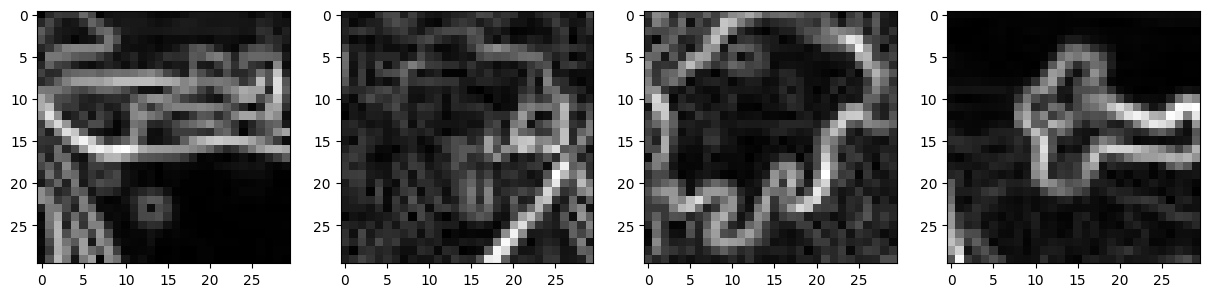

In [5]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 4, figsize = (15, 5))
axes[0].imshow(train_images_s[5477], cmap = "gray")
axes[1].imshow(train_images_s[235], cmap = "gray")
axes[2].imshow(train_images_s[45778], cmap = "gray")
axes[3].imshow(train_images_s[1234], cmap = "gray")

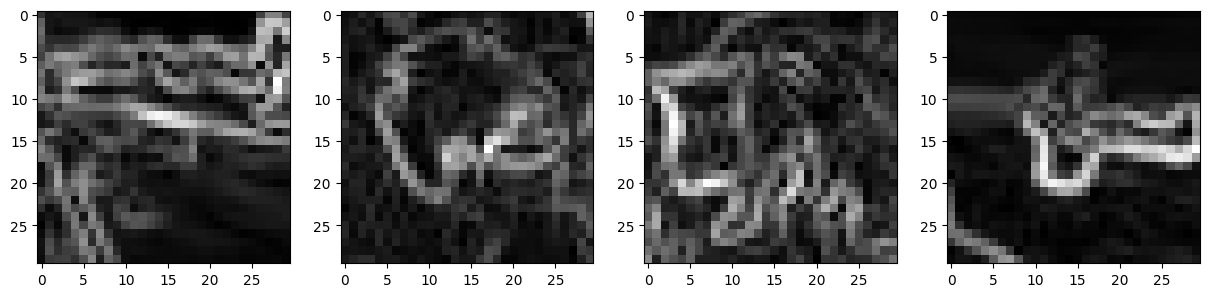

In [6]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 4, figsize = (15, 5))
axes[0].imshow(train_images_v[5477], cmap = "gray")
axes[1].imshow(train_images_v[235], cmap = "gray")
axes[2].imshow(train_images_v[45778], cmap = "gray")
axes[3].imshow(train_images_v[1234], cmap = "gray")

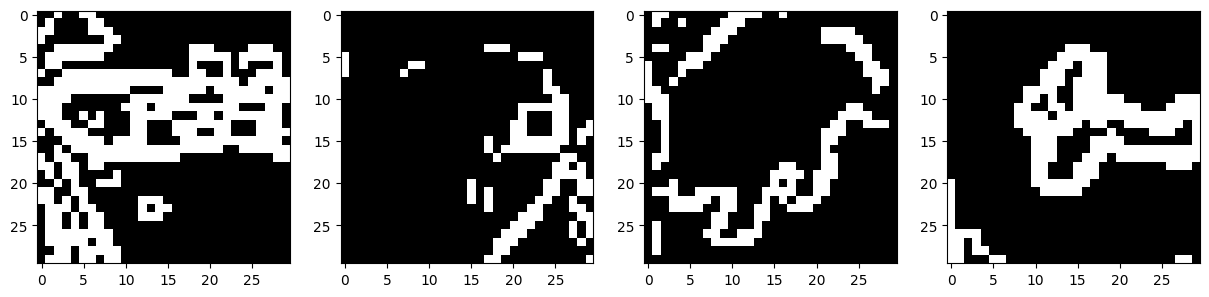

In [7]:
import gtda.images

def transform(data: numpy.ndarray):
    return (data > 0.8)

figure, axes = plt.subplots(1, 4, figsize = (15, 5))
axes[0].imshow(transform(train_images_s[5477]), cmap = "gray")
axes[1].imshow(transform(train_images_s[235]), cmap = "gray")
axes[2].imshow(transform(train_images_s[45778]), cmap = "gray")
axes[3].imshow(transform(train_images_s[1234]), cmap = "gray")

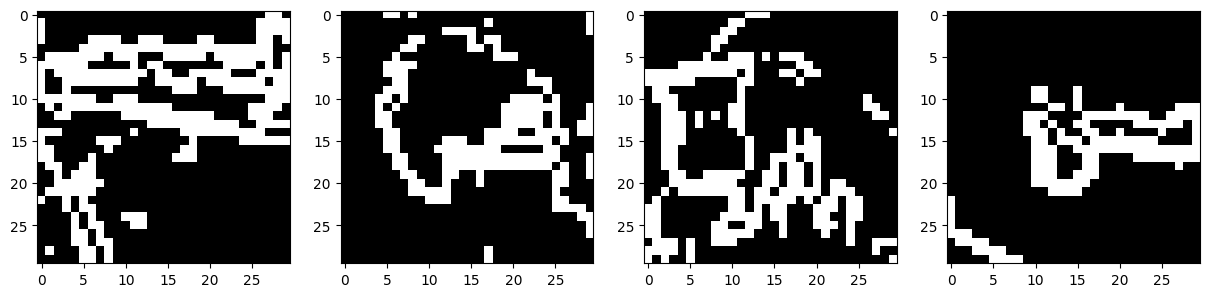

In [8]:
import gtda.images

def transform(data: numpy.ndarray):
    return (data > 0.8)

figure, axes = plt.subplots(1, 4, figsize = (15, 5))
axes[0].imshow(transform(train_images_v[5477]), cmap = "gray")
axes[1].imshow(transform(train_images_v[235]), cmap = "gray")
axes[2].imshow(transform(train_images_v[45778]), cmap = "gray")
axes[3].imshow(transform(train_images_v[1234]), cmap = "gray")

### Features

In [9]:
import os
import cvtda.topology

def make_features(train, test, name: str, binarizer, filtration):
    if os.path.exists(f"8/{name}/test_features.npy"):
        return

    if binarizer is not None:
        train = binarizer.fit_transform(train)
        test = binarizer.transform(test)
        
    if filtration is not None:
        train = filtration.fit_transform(train)
        test = filtration.transform(test)

    filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(homology_dimensions = [ 0, 1 ])
    train = filtrations_to_diagrams.fit_transform(train)
    test = filtrations_to_diagrams.transform(test)
    print(train.shape, test.shape)

    n_bins = (64 if len(train[0]) < 256 else 128)
    print(f"Bins: {n_bins}")
    digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 625, n_bins = n_bins)
    train = digrams_to_features.fit_transform(train)
    test = digrams_to_features.transform(test)
    print(train.shape, test.shape)

    os.makedirs(f"8/{name}", exist_ok = True)
    numpy.save(f"8/{name}/train_features.npy", train)
    numpy.save(f"8/{name}/test_features.npy", test)


In [10]:
import itertools
import gtda.images

make_features(train_images_s, test_images_s, "s/raw", binarizer = None, filtration = None)

greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    binarizer_threshold = 0.4,
    radial_filtration_centers = list(itertools.product([ 3, 8, 13, 18, 23, 28 ], [ 3, 8, 13, 18, 23, 28 ]))
)
for i, filtration in enumerate(greyscale_to_filtrations.filtrations_):
    print(f"{i}/{len(greyscale_to_filtrations.filtrations_)}). {filtration}")
    make_features(
        train_images_s,
        test_images_s,
        f"s/{type(filtration).__name__}{i}",
        binarizer = gtda.images.Binarizer(threshold = 0.4),
        filtration = filtration
    )

0/49). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
1/49). HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5107.80it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6321.11it/s]


(50000, 52, 3) (10000, 50, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


Fitting complete


Batch:   0%|          | 0/80 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Batch: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]


(50000, 260) (10000, 260)
2/49). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:11<00:00, 4301.03it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5896.69it/s]


(50000, 53, 3) (10000, 51, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


(50000, 260) (10000, 260)
3/49). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4648.12it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6186.68it/s]


(50000, 53, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


(50000, 260) (10000, 260)
4/49). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5084.51it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6324.08it/s]


(50000, 53, 3) (10000, 50, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


(50000, 260) (10000, 260)
5/49). HeightFiltration(direction=array([0, 1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5128.01it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6389.68it/s]


(50000, 53, 3) (10000, 50, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]


(50000, 260) (10000, 260)
6/49). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5162.53it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6261.21it/s]


(50000, 50, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


(50000, 260) (10000, 260)
7/49). HeightFiltration(direction=array([1, 0]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5132.49it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6339.25it/s]


(50000, 51, 3) (10000, 49, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


(50000, 260) (10000, 260)
8/49). RadialFiltration(center=array([3, 3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5235.94it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6414.63it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


(50000, 260) (10000, 260)
9/49). RadialFiltration(center=array([3, 8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4991.95it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6002.39it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


(50000, 260) (10000, 260)
10/49). RadialFiltration(center=array([ 3, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5186.01it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5686.02it/s]


(50000, 56, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


(50000, 260) (10000, 260)
11/49). RadialFiltration(center=array([ 3, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5283.04it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6569.41it/s]


(50000, 55, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


(50000, 260) (10000, 260)
12/49). RadialFiltration(center=array([ 3, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5295.90it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6261.44it/s]


(50000, 57, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s]


(50000, 260) (10000, 260)
13/49). RadialFiltration(center=array([ 3, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5339.72it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6458.98it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


(50000, 260) (10000, 260)
14/49). RadialFiltration(center=array([8, 3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5269.47it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6653.68it/s]


(50000, 55, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


(50000, 260) (10000, 260)
15/49). RadialFiltration(center=array([8, 8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5095.33it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6599.43it/s]


(50000, 55, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


(50000, 260) (10000, 260)
16/49). RadialFiltration(center=array([ 8, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5143.53it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6462.65it/s]


(50000, 56, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


(50000, 260) (10000, 260)
17/49). RadialFiltration(center=array([ 8, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5214.98it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6194.56it/s]


(50000, 56, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


(50000, 260) (10000, 260)
18/49). RadialFiltration(center=array([ 8, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4887.66it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6118.93it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


(50000, 260) (10000, 260)
19/49). RadialFiltration(center=array([ 8, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4990.30it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6081.69it/s]


(50000, 57, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


(50000, 260) (10000, 260)
20/49). RadialFiltration(center=array([13,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4560.24it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6110.43it/s]


(50000, 58, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]


(50000, 260) (10000, 260)
21/49). RadialFiltration(center=array([13,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5048.50it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6012.93it/s]


(50000, 57, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


(50000, 260) (10000, 260)
22/49). RadialFiltration(center=array([13, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5031.63it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6149.11it/s]


(50000, 56, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


(50000, 260) (10000, 260)
23/49). RadialFiltration(center=array([13, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5034.64it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6106.06it/s]


(50000, 56, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


(50000, 260) (10000, 260)
24/49). RadialFiltration(center=array([13, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:11<00:00, 4465.98it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6226.62it/s]


(50000, 57, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


(50000, 260) (10000, 260)
25/49). RadialFiltration(center=array([13, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4789.21it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6117.42it/s]


(50000, 58, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


(50000, 260) (10000, 260)
26/49). RadialFiltration(center=array([18,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5032.94it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6054.26it/s]


(50000, 61, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


(50000, 260) (10000, 260)
27/49). RadialFiltration(center=array([18,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4914.31it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6000.53it/s]


(50000, 58, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


(50000, 260) (10000, 260)
28/49). RadialFiltration(center=array([18, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4794.03it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5929.84it/s]


(50000, 56, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]


(50000, 260) (10000, 260)
29/49). RadialFiltration(center=array([18, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4881.66it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5893.16it/s]


(50000, 55, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


(50000, 260) (10000, 260)
30/49). RadialFiltration(center=array([18, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4862.02it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6055.87it/s]


(50000, 57, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


(50000, 260) (10000, 260)
31/49). RadialFiltration(center=array([18, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4966.19it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6059.77it/s]


(50000, 58, 3) (10000, 51, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


(50000, 260) (10000, 260)
32/49). RadialFiltration(center=array([23,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:11<00:00, 4369.99it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5995.50it/s]


(50000, 58, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


(50000, 260) (10000, 260)
33/49). RadialFiltration(center=array([23,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4950.86it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5803.94it/s]


(50000, 55, 3) (10000, 58, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]


(50000, 260) (10000, 260)
34/49). RadialFiltration(center=array([23, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4833.93it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5863.58it/s]


(50000, 53, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


(50000, 260) (10000, 260)
35/49). RadialFiltration(center=array([23, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4902.45it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:02<00:00, 4917.23it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]


(50000, 260) (10000, 260)
36/49). RadialFiltration(center=array([23, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4590.03it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5898.42it/s]


(50000, 57, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


(50000, 260) (10000, 260)
37/49). RadialFiltration(center=array([23, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:11<00:00, 4464.39it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5657.99it/s]


(50000, 57, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


(50000, 260) (10000, 260)
38/49). RadialFiltration(center=array([28,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4712.09it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5157.69it/s]


(50000, 54, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]


(50000, 260) (10000, 260)
39/49). RadialFiltration(center=array([28,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4732.35it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5650.18it/s]


(50000, 54, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


(50000, 260) (10000, 260)
40/49). RadialFiltration(center=array([28, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4812.59it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6055.27it/s]


(50000, 56, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


(50000, 260) (10000, 260)
41/49). RadialFiltration(center=array([28, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4749.21it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5795.77it/s]


(50000, 54, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]


(50000, 260) (10000, 260)
42/49). RadialFiltration(center=array([28, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4904.46it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6013.68it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


(50000, 260) (10000, 260)
43/49). RadialFiltration(center=array([28, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4872.68it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:02<00:00, 4191.65it/s]


(50000, 55, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


(50000, 260) (10000, 260)
44/49). DilationFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:08<00:00, 5711.34it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6752.92it/s]


(50000, 70, 3) (10000, 65, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


(50000, 260) (10000, 260)
45/49). ErosionFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5043.65it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6245.79it/s]


(50000, 55, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


(50000, 260) (10000, 260)
46/49). SignedDistanceFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:08<00:00, 5678.73it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 7032.50it/s]


(50000, 69, 3) (10000, 66, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


(50000, 260) (10000, 260)
47/49). DensityFiltration(n_jobs=-1, radius=1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:11<00:00, 4389.69it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6062.79it/s]


(50000, 75, 3) (10000, 66, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


(50000, 260) (10000, 260)
48/49). DensityFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4983.00it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5967.35it/s]


(50000, 58, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

(50000, 260) (10000, 260)


In [11]:
import itertools
import gtda.images

make_features(train_images_v, test_images_v, "v/raw", binarizer = None, filtration = None)

greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    binarizer_threshold = 0.4,
    radial_filtration_centers = list(itertools.product([ 3, 8, 13, 18, 23, 28 ], [ 3, 8, 13, 18, 23, 28 ]))
)
for i, filtration in enumerate(greyscale_to_filtrations.filtrations_):
    print(f"{i}/{len(greyscale_to_filtrations.filtrations_)}). {filtration}")
    make_features(
        train_images_v,
        test_images_v,
        f"v/{type(filtration).__name__}{i}",
        binarizer = gtda.images.Binarizer(threshold = 0.4),
        filtration = filtration
    )

Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:07<00:00, 7095.12it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 7410.13it/s]


(50000, 253, 3) (10000, 299, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


(50000, 260) (10000, 260)
0/49). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5205.34it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5592.52it/s]


(50000, 59, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


(50000, 260) (10000, 260)
1/49). HeightFiltration(direction=array([1, 1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5120.90it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5698.66it/s]


(50000, 56, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


(50000, 260) (10000, 260)
2/49). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5103.24it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5739.91it/s]


(50000, 62, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


(50000, 260) (10000, 260)
3/49). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5248.92it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5945.89it/s]


(50000, 58, 3) (10000, 54, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


(50000, 260) (10000, 260)
4/49). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5202.99it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6292.52it/s]


(50000, 58, 3) (10000, 52, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


(50000, 260) (10000, 260)
5/49). HeightFiltration(direction=array([0, 1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5223.37it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6285.79it/s]


(50000, 58, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


(50000, 260) (10000, 260)
6/49). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4641.98it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5886.41it/s]


(50000, 55, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


(50000, 260) (10000, 260)
7/49). HeightFiltration(direction=array([1, 0]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5127.47it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6282.03it/s]


(50000, 56, 3) (10000, 53, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


(50000, 260) (10000, 260)
8/49). RadialFiltration(center=array([3, 3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5242.86it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5347.95it/s]


(50000, 62, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


(50000, 260) (10000, 260)
9/49). RadialFiltration(center=array([3, 8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5181.73it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6258.65it/s]


(50000, 62, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


(50000, 260) (10000, 260)
10/49). RadialFiltration(center=array([ 3, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5256.20it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6450.49it/s]


(50000, 60, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


(50000, 260) (10000, 260)
11/49). RadialFiltration(center=array([ 3, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5312.53it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6484.69it/s]


(50000, 61, 3) (10000, 58, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


(50000, 260) (10000, 260)
12/49). RadialFiltration(center=array([ 3, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5327.89it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6328.19it/s]


(50000, 61, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]


(50000, 260) (10000, 260)
13/49). RadialFiltration(center=array([ 3, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4574.43it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5955.33it/s]


(50000, 64, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]


(50000, 260) (10000, 260)
14/49). RadialFiltration(center=array([8, 3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5355.04it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6673.36it/s]


(50000, 61, 3) (10000, 60, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


(50000, 260) (10000, 260)
15/49). RadialFiltration(center=array([8, 8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4876.46it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6604.52it/s]


(50000, 60, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


(50000, 260) (10000, 260)
16/49). RadialFiltration(center=array([ 8, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4900.05it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6663.68it/s]


(50000, 59, 3) (10000, 58, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


(50000, 260) (10000, 260)
17/49). RadialFiltration(center=array([ 8, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4876.90it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6593.96it/s]


(50000, 61, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


(50000, 260) (10000, 260)
18/49). RadialFiltration(center=array([ 8, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4830.21it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6587.97it/s]


(50000, 62, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


(50000, 260) (10000, 260)
19/49). RadialFiltration(center=array([ 8, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4929.05it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6512.69it/s]


(50000, 64, 3) (10000, 58, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


(50000, 260) (10000, 260)
20/49). RadialFiltration(center=array([13,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4700.24it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6553.67it/s]


(50000, 59, 3) (10000, 61, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


(50000, 260) (10000, 260)
21/49). RadialFiltration(center=array([13,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5343.69it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6715.08it/s]


(50000, 61, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


(50000, 260) (10000, 260)
22/49). RadialFiltration(center=array([13, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5357.39it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6574.83it/s]


(50000, 61, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


(50000, 260) (10000, 260)
23/49). RadialFiltration(center=array([13, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5385.89it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6723.50it/s]


(50000, 62, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


(50000, 260) (10000, 260)
24/49). RadialFiltration(center=array([13, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5217.04it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6749.52it/s]


(50000, 62, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


(50000, 260) (10000, 260)
25/49). RadialFiltration(center=array([13, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5369.20it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6592.00it/s]


(50000, 65, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]


(50000, 260) (10000, 260)
26/49). RadialFiltration(center=array([18,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5371.85it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6119.19it/s]


(50000, 59, 3) (10000, 62, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]


(50000, 260) (10000, 260)
27/49). RadialFiltration(center=array([18,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5365.83it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6125.49it/s]


(50000, 61, 3) (10000, 62, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]


(50000, 260) (10000, 260)
28/49). RadialFiltration(center=array([18, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4802.78it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6313.08it/s]


(50000, 62, 3) (10000, 60, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


(50000, 260) (10000, 260)
29/49). RadialFiltration(center=array([18, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4822.65it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6325.18it/s]


(50000, 60, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


(50000, 260) (10000, 260)
30/49). RadialFiltration(center=array([18, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5227.60it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6643.43it/s]


(50000, 59, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


(50000, 260) (10000, 260)
31/49). RadialFiltration(center=array([18, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5419.54it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6695.89it/s]


(50000, 61, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


(50000, 260) (10000, 260)
32/49). RadialFiltration(center=array([23,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5393.84it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:02<00:00, 4761.36it/s]


(50000, 60, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]


(50000, 260) (10000, 260)
33/49). RadialFiltration(center=array([23,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5396.10it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6441.69it/s]


(50000, 61, 3) (10000, 59, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


(50000, 260) (10000, 260)
34/49). RadialFiltration(center=array([23, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5386.94it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6445.46it/s]


(50000, 60, 3) (10000, 58, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]


(50000, 260) (10000, 260)
35/49). RadialFiltration(center=array([23, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5303.42it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6645.26it/s]


(50000, 60, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


(50000, 260) (10000, 260)
36/49). RadialFiltration(center=array([23, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5390.31it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6702.83it/s]


(50000, 59, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


(50000, 260) (10000, 260)
37/49). RadialFiltration(center=array([23, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5415.61it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6745.52it/s]


(50000, 59, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


(50000, 260) (10000, 260)
38/49). RadialFiltration(center=array([28,  3]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5338.33it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6029.66it/s]


(50000, 60, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


(50000, 260) (10000, 260)
39/49). RadialFiltration(center=array([28,  8]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5293.26it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6188.49it/s]


(50000, 61, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


(50000, 260) (10000, 260)
40/49). RadialFiltration(center=array([28, 13]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5247.37it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6427.90it/s]


(50000, 61, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


(50000, 260) (10000, 260)
41/49). RadialFiltration(center=array([28, 18]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5147.48it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6459.63it/s]


(50000, 61, 3) (10000, 57, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


(50000, 260) (10000, 260)
42/49). RadialFiltration(center=array([28, 23]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5178.76it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6584.93it/s]


(50000, 61, 3) (10000, 56, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


(50000, 260) (10000, 260)
43/49). RadialFiltration(center=array([28, 28]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5135.88it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6268.15it/s]


(50000, 60, 3) (10000, 55, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


(50000, 260) (10000, 260)
44/49). DilationFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5507.82it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6602.97it/s]


(50000, 66, 3) (10000, 66, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


(50000, 260) (10000, 260)
45/49). ErosionFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4925.14it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 5687.64it/s]


(50000, 61, 3) (10000, 62, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


(50000, 260) (10000, 260)
46/49). SignedDistanceFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4737.40it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6522.21it/s]


(50000, 66, 3) (10000, 74, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


(50000, 260) (10000, 260)
47/49). DensityFiltration(n_jobs=-1, radius=1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:09<00:00, 5149.22it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6284.24it/s]


(50000, 79, 3) (10000, 91, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


(50000, 260) (10000, 260)
48/49). DensityFiltration(n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [00:10<00:00, 4984.47it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:01<00:00, 6490.96it/s]


(50000, 66, 3) (10000, 61, 3)
Bins: 64
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Fitting complete


Batch: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]

(50000, 260) (10000, 260)


In [13]:
import os

train_features = numpy.hstack(
    [
        numpy.load(f"8/s/{folder}/train_features.npy")
        for folder in os.listdir("8/s")
    ]
    +
    [
        numpy.load(f"8/v/{folder}/train_features.npy")
        for folder in os.listdir("8/v")
    ]
)

test_features = numpy.hstack(
    [
        numpy.load(f"8/s/{folder}/test_features.npy")
        for folder in os.listdir("8/s")
    ]
    +
    [
        numpy.load(f"8/v/{folder}/test_features.npy")
        for folder in os.listdir("8/v")
    ]
)

train_features.shape, test_features.shape

((50000, 26000), (10000, 26000))

In [14]:
train_features.min(), train_features.max()

(-140.0, 175247.39125243842)

### Classify raw features

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3095, 'TOP-2 Accuracy': 0.4944, 'TOP-3 Accuracy': 0.6208, 'TOP-4 Accuracy': 0.7176, 'TOP-5 Accuracy': 0.7913, 'TOP-6 Accuracy': 0.8521, 'TOP-7 Accuracy': 0.9036, 'TOP-8 Accuracy': 0.9454, 'TOP-9 Accuracy': 0.9776, 'AUC-ROC': 0.749197761111111, 'Precision': 0.2972471287808777, 'Recall': 0.3095, 'F1-score': 0.3000124358671215}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3881, 'TOP-2 Accuracy': 0.5763, 'TOP-3 Accuracy': 0.6894, 'TOP-4 Accuracy': 0.7764, 'TOP-5 Accuracy': 0.8414, 'TOP-6 Accuracy': 0.895, 'TOP-7 Accuracy': 0.932, 'TOP-8 Accuracy': 0.9609, 'TOP-9 Accuracy': 0.9834, 'AUC-ROC': 0.8032042222222221, 'Precision': 0.3823818762501463, 'Recall': 0.3881, 'F1-score': 0.3831452148646347}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF214F5570>
Input to LazyLinear: 26000
Parameters

100%|██████████| 25/25 [01:26<00:00,  3.48s/it, loss=1.06e+5, val_acc=0.301]


{'classifier': 'NNClassifier', 'Accuracy': 0.3009, 'TOP-2 Accuracy': 0.4812, 'TOP-3 Accuracy': 0.6048, 'TOP-4 Accuracy': 0.7011, 'TOP-5 Accuracy': 0.7729, 'TOP-6 Accuracy': 0.8293, 'TOP-7 Accuracy': 0.8749, 'TOP-8 Accuracy': 0.925, 'TOP-9 Accuracy': 0.964, 'AUC-ROC': 0.7439563888888888, 'Precision': 0.36765987045283144, 'Recall': 0.3009, 'F1-score': 0.27056933326955235}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3917, 'TOP-2 Accuracy': 0.5902, 'TOP-3 Accuracy': 0.7065, 'TOP-4 Accuracy': 0.7969, 'TOP-5 Accuracy': 0.8602, 'TOP-6 Accuracy': 0.9079, 'TOP-7 Accuracy': 0.9437, 'TOP-8 Accuracy': 0.9708, 'TOP-9 Accuracy': 0.9873, 'AUC-ROC': 0.8164279555555557, 'Precision': 0.3818332374948239, 'Recall': 0.39170000000000005, 'F1-score': 0.38269978198431315}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF214F5090>
Learning rate set t

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.4136, 'TOP-2 Accuracy': 0.6114, 'TOP-3 Accuracy': 0.7286, 'TOP-4 Accuracy': 0.8104, 'TOP-5 Accuracy': 0.8743, 'TOP-6 Accuracy': 0.9178, 'TOP-7 Accuracy': 0.9516, 'TOP-8 Accuracy': 0.9745, 'TOP-9 Accuracy': 0.9894, 'AUC-ROC': 0.8308193333333334, 'Precision': 0.40698456839751385, 'Recall': 0.4136, 'F1-score': 0.4082509455663281}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3095,0.4944,0.6208,0.7176,0.7913,0.8521,0.9036,0.9454,0.9776,0.749198,0.297247,0.3095,0.300012
1,RandomForestClassifier,0.3881,0.5763,0.6894,0.7764,0.8414,0.8950,0.9320,0.9609,0.9834,0.803204,0.382382,0.3881,0.383145
2,NNClassifier,0.3009,0.4812,0.6048,0.7011,0.7729,0.8293,0.8749,0.9250,0.9640,0.743956,0.367660,0.3009,0.270569
3,HistGradientBoostingClassifier,0.3917,0.5902,0.7065,0.7969,0.8602,0.9079,0.9437,0.9708,0.9873,0.816428,0.381833,0.3917,0.382700
4,CatBoostClassifier,0.4483,0.6461,0.7596,0.8358,0.8910,0.9323,0.9606,0.9796,0.9924,0.849847,0.443494,0.4483,0.444762
5,XGBClassifier,0.4136,0.6114,0.7286,0.8104,0.8743,0.9178,0.9516,0.9745,0.9894,0.830819,0.406985,0.4136,0.408251


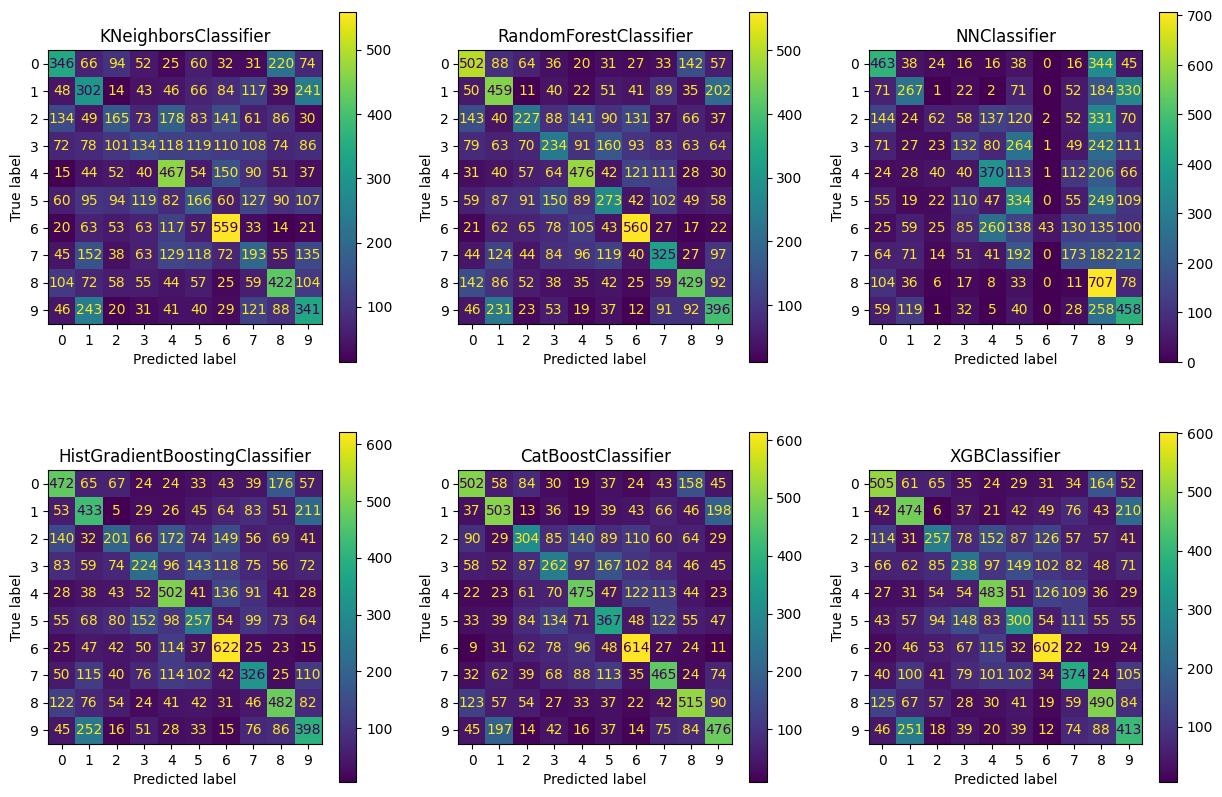

In [15]:
import cvtda.classification

cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### StandardScaler

In [16]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(train_features)
test_features = selected_standard_scaler.transform(test_features)

train_features.shape, test_features.shape

((50000, 26000), (10000, 26000))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3029, 'TOP-2 Accuracy': 0.486, 'TOP-3 Accuracy': 0.609, 'TOP-4 Accuracy': 0.7035, 'TOP-5 Accuracy': 0.7808, 'TOP-6 Accuracy': 0.8473, 'TOP-7 Accuracy': 0.899, 'TOP-8 Accuracy': 0.941, 'TOP-9 Accuracy': 0.9738, 'AUC-ROC': 0.7439228555555554, 'Precision': 0.30675798795219494, 'Recall': 0.30289999999999995, 'F1-score': 0.2982619326018371}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3816, 'TOP-2 Accuracy': 0.5727, 'TOP-3 Accuracy': 0.6893, 'TOP-4 Accuracy': 0.7778, 'TOP-5 Accuracy': 0.8421, 'TOP-6 Accuracy': 0.894, 'TOP-7 Accuracy': 0.9314, 'TOP-8 Accuracy': 0.9618, 'TOP-9 Accuracy': 0.983, 'AUC-ROC': 0.8027223666666666, 'Precision': 0.37541605836061154, 'Recall': 0.3816, 'F1-score': 0.3763998784158748}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF24CFB790>
Input to LazyLinear: 2600

100%|██████████| 25/25 [01:28<00:00,  3.54s/it, loss=1.01e+5, val_acc=0.419]


{'classifier': 'NNClassifier', 'Accuracy': 0.4192, 'TOP-2 Accuracy': 0.6109, 'TOP-3 Accuracy': 0.717, 'TOP-4 Accuracy': 0.7949, 'TOP-5 Accuracy': 0.8563, 'TOP-6 Accuracy': 0.906, 'TOP-7 Accuracy': 0.9425, 'TOP-8 Accuracy': 0.9669, 'TOP-9 Accuracy': 0.9837, 'AUC-ROC': 0.8084134111111111, 'Precision': 0.4067109520378917, 'Recall': 0.4192, 'F1-score': 0.4084047555484854}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.388, 'TOP-2 Accuracy': 0.5874, 'TOP-3 Accuracy': 0.7083, 'TOP-4 Accuracy': 0.7965, 'TOP-5 Accuracy': 0.8593, 'TOP-6 Accuracy': 0.9071, 'TOP-7 Accuracy': 0.9437, 'TOP-8 Accuracy': 0.9715, 'TOP-9 Accuracy': 0.988, 'AUC-ROC': 0.8158405999999999, 'Precision': 0.37722040742651947, 'Recall': 0.38799999999999996, 'F1-score': 0.3785440543009467}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF24CF9540>
Learning rate set to 0.

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3029,0.4860,0.6090,0.7035,0.7808,0.8473,0.8990,0.9410,0.9738,0.743923,0.306758,0.3029,0.298262
1,RandomForestClassifier,0.3816,0.5727,0.6893,0.7778,0.8421,0.8940,0.9314,0.9618,0.9830,0.802722,0.375416,0.3816,0.376400
2,NNClassifier,0.4192,0.6109,0.7170,0.7949,0.8563,0.9060,0.9425,0.9669,0.9837,0.808413,0.406711,0.4192,0.408405
3,HistGradientBoostingClassifier,0.3880,0.5874,0.7083,0.7965,0.8593,0.9071,0.9437,0.9715,0.9880,0.815841,0.377220,0.3880,0.378544
4,CatBoostClassifier,0.4447,0.6470,0.7569,0.8361,0.8889,0.9301,0.9592,0.9788,0.9922,0.849257,0.439624,0.4447,0.441167
5,XGBClassifier,0.4128,0.6124,0.7316,0.8135,0.8735,0.9177,0.9518,0.9743,0.9907,0.830812,0.405406,0.4128,0.406499


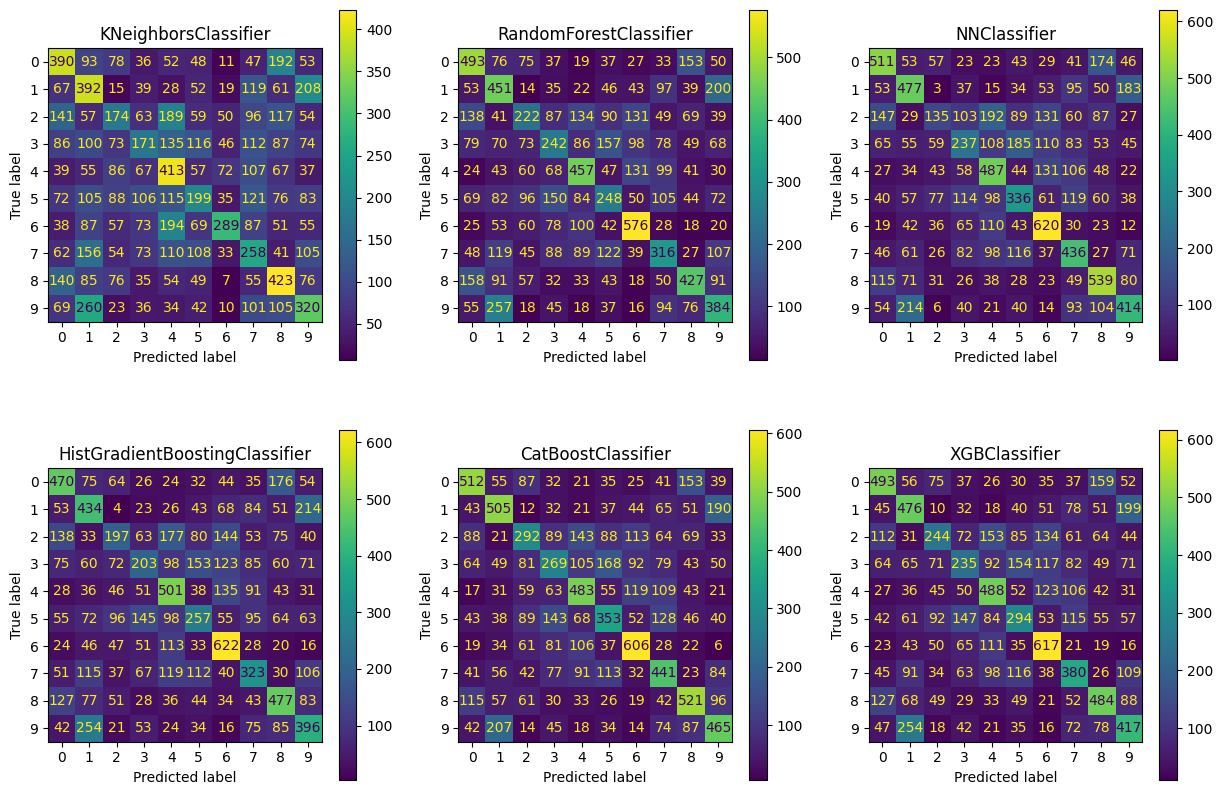

In [17]:
import cvtda.classification

cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### VarianceThreshold & DuplicatesRemover

In [18]:
import sklearn.feature_selection

variance_threshold = sklearn.feature_selection.VarianceThreshold(threshold = 1e-8)
train_features = variance_threshold.fit_transform(train_features)
test_features = variance_threshold.transform(test_features)

train_features.shape, test_features.shape

((50000, 24789), (10000, 24789))

In [19]:
import cvtda.utils

duplicates_remover = cvtda.utils.DuplicateFeaturesRemover()
train_features = duplicates_remover.fit_transform(train_features)
test_features = duplicates_remover.transform(test_features)

train_features.shape, test_features.shape

100%|██████████| 15838/15838 [01:02<00:00, 254.81it/s, partition_by=0, num_features=3, duplicates=9340] 


Found 9342 duplicates


((50000, 15447), (10000, 15447))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3095, 'TOP-2 Accuracy': 0.4874, 'TOP-3 Accuracy': 0.6139, 'TOP-4 Accuracy': 0.7058, 'TOP-5 Accuracy': 0.7805, 'TOP-6 Accuracy': 0.8494, 'TOP-7 Accuracy': 0.8999, 'TOP-8 Accuracy': 0.9417, 'TOP-9 Accuracy': 0.9747, 'AUC-ROC': 0.74525765, 'Precision': 0.3121057435747935, 'Recall': 0.3095, 'F1-score': 0.3047616880084315}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3823, 'TOP-2 Accuracy': 0.5727, 'TOP-3 Accuracy': 0.69, 'TOP-4 Accuracy': 0.776, 'TOP-5 Accuracy': 0.841, 'TOP-6 Accuracy': 0.8928, 'TOP-7 Accuracy': 0.9303, 'TOP-8 Accuracy': 0.9595, 'TOP-9 Accuracy': 0.9836, 'AUC-ROC': 0.8012303166666668, 'Precision': 0.3771678677950393, 'Recall': 0.38230000000000003, 'F1-score': 0.3776182537675634}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF21F6F400>
Input to LazyLinear: 15447
Parame

100%|██████████| 25/25 [04:36<00:00, 11.04s/it, loss=1.02e+5, val_acc=0.42] 


{'classifier': 'NNClassifier', 'Accuracy': 0.4203, 'TOP-2 Accuracy': 0.6131, 'TOP-3 Accuracy': 0.7221, 'TOP-4 Accuracy': 0.8004, 'TOP-5 Accuracy': 0.8579, 'TOP-6 Accuracy': 0.9033, 'TOP-7 Accuracy': 0.9342, 'TOP-8 Accuracy': 0.9639, 'TOP-9 Accuracy': 0.9841, 'AUC-ROC': 0.8073051388888888, 'Precision': 0.4061701991012499, 'Recall': 0.42029999999999995, 'F1-score': 0.40843070072809057}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3879, 'TOP-2 Accuracy': 0.5892, 'TOP-3 Accuracy': 0.7052, 'TOP-4 Accuracy': 0.794, 'TOP-5 Accuracy': 0.859, 'TOP-6 Accuracy': 0.9109, 'TOP-7 Accuracy': 0.9453, 'TOP-8 Accuracy': 0.9706, 'TOP-9 Accuracy': 0.9873, 'AUC-ROC': 0.8165448222222222, 'Precision': 0.3784527617951149, 'Recall': 0.3879, 'F1-score': 0.3790687203097162}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF21BAF880>
Learning rate set to 

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3095,0.4874,0.6139,0.7058,0.7805,0.8494,0.8999,0.9417,0.9747,0.745258,0.312106,0.3095,0.304762
1,RandomForestClassifier,0.3823,0.5727,0.6900,0.7760,0.8410,0.8928,0.9303,0.9595,0.9836,0.801230,0.377168,0.3823,0.377618
2,NNClassifier,0.4203,0.6131,0.7221,0.8004,0.8579,0.9033,0.9342,0.9639,0.9841,0.807305,0.406170,0.4203,0.408431
3,HistGradientBoostingClassifier,0.3879,0.5892,0.7052,0.7940,0.8590,0.9109,0.9453,0.9706,0.9873,0.816545,0.378453,0.3879,0.379069
4,CatBoostClassifier,0.4443,0.6468,0.7573,0.8350,0.8899,0.9307,0.9624,0.9793,0.9926,0.849608,0.439746,0.4443,0.441015
5,XGBClassifier,0.4128,0.6124,0.7316,0.8134,0.8734,0.9177,0.9518,0.9743,0.9907,0.830809,0.405399,0.4128,0.406497


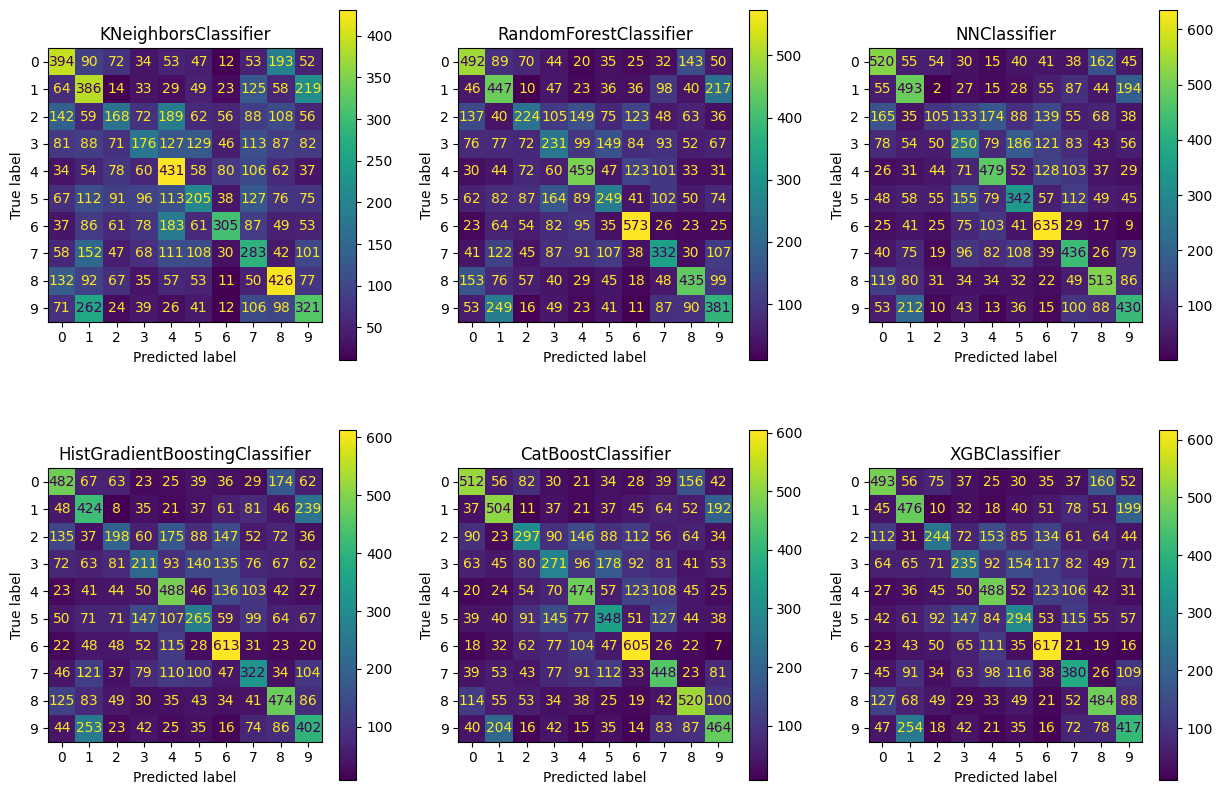

In [20]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### InformationValueFeatureSelector

Fitting the information value feature selector


information values: 100%|██████████| 15447/15447 [02:22<00:00, 108.58it/s]


Fitting complete


((50000, 7951), (10000, 7951))

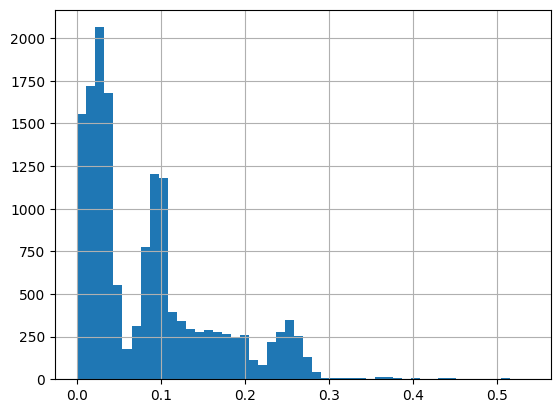

In [21]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.05, bins = 50)

train_features = feature_selector.fit_transform(train_features, train_labels)
test_features = feature_selector.transform(test_features)

feature_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3186, 'TOP-2 Accuracy': 0.5035, 'TOP-3 Accuracy': 0.6256, 'TOP-4 Accuracy': 0.7171, 'TOP-5 Accuracy': 0.7962, 'TOP-6 Accuracy': 0.8521, 'TOP-7 Accuracy': 0.9017, 'TOP-8 Accuracy': 0.9419, 'TOP-9 Accuracy': 0.9735, 'AUC-ROC': 0.7552971833333334, 'Precision': 0.3218920045070672, 'Recall': 0.3186, 'F1-score': 0.314552055144448}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3846, 'TOP-2 Accuracy': 0.575, 'TOP-3 Accuracy': 0.6901, 'TOP-4 Accuracy': 0.7716, 'TOP-5 Accuracy': 0.8402, 'TOP-6 Accuracy': 0.891, 'TOP-7 Accuracy': 0.9327, 'TOP-8 Accuracy': 0.9628, 'TOP-9 Accuracy': 0.9857, 'AUC-ROC': 0.8028065888888888, 'Precision': 0.37966310980775864, 'Recall': 0.3846, 'F1-score': 0.38000920779301}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF24B9F5B0>
Input to LazyLinear: 7951
Parameters: 

100%|██████████| 25/25 [02:32<00:00,  6.12s/it, loss=1.02e+5, val_acc=0.422]


{'classifier': 'NNClassifier', 'Accuracy': 0.4224, 'TOP-2 Accuracy': 0.616, 'TOP-3 Accuracy': 0.7284, 'TOP-4 Accuracy': 0.804, 'TOP-5 Accuracy': 0.859, 'TOP-6 Accuracy': 0.9029, 'TOP-7 Accuracy': 0.939, 'TOP-8 Accuracy': 0.9643, 'TOP-9 Accuracy': 0.9833, 'AUC-ROC': 0.8106411277777776, 'Precision': 0.4061042574099364, 'Recall': 0.4224, 'F1-score': 0.4058419696341346}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3896, 'TOP-2 Accuracy': 0.5882, 'TOP-3 Accuracy': 0.706, 'TOP-4 Accuracy': 0.7946, 'TOP-5 Accuracy': 0.8607, 'TOP-6 Accuracy': 0.9095, 'TOP-7 Accuracy': 0.9448, 'TOP-8 Accuracy': 0.9709, 'TOP-9 Accuracy': 0.9869, 'AUC-ROC': 0.8158632222222222, 'Precision': 0.38017472077080183, 'Recall': 0.3896, 'F1-score': 0.38084003810673417}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF239AD9C0>
Learning rate set to 0.309284
0:	lea

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3186,0.5035,0.6256,0.7171,0.7962,0.8521,0.9017,0.9419,0.9735,0.755297,0.321892,0.3186,0.314552
1,RandomForestClassifier,0.3846,0.5750,0.6901,0.7716,0.8402,0.8910,0.9327,0.9628,0.9857,0.802807,0.379663,0.3846,0.380009
2,NNClassifier,0.4224,0.6160,0.7284,0.8040,0.8590,0.9029,0.9390,0.9643,0.9833,0.810641,0.406104,0.4224,0.405842
3,HistGradientBoostingClassifier,0.3896,0.5882,0.7060,0.7946,0.8607,0.9095,0.9448,0.9709,0.9869,0.815863,0.380175,0.3896,0.380840
4,CatBoostClassifier,0.4491,0.6463,0.7562,0.8340,0.8937,0.9316,0.9609,0.9799,0.9925,0.849638,0.443951,0.4491,0.445562
5,XGBClassifier,0.4155,0.6147,0.7305,0.8160,0.8731,0.9171,0.9502,0.9752,0.9905,0.831248,0.409033,0.4155,0.410138


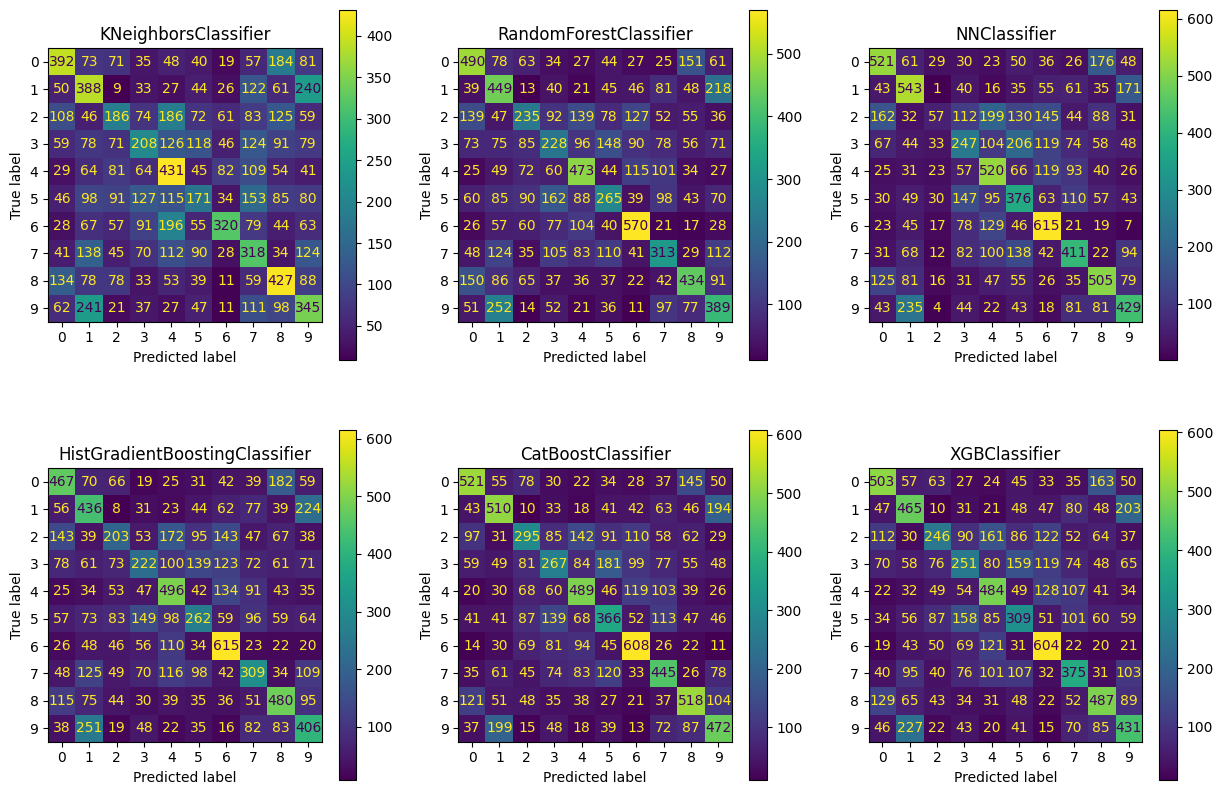

In [22]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### CorrelationSelector

Fitting the correlations feature selector
Fitting complete


((50000, 6129), (10000, 6129))

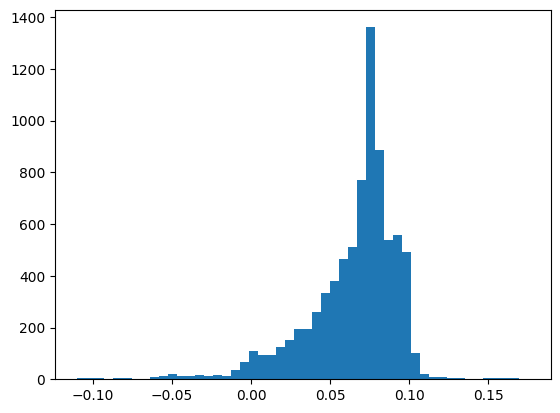

In [23]:
correlation_selector = cvtda.classification.CorrelationSelector(threshold = 0.05)

train_features = correlation_selector.fit_transform(train_features, train_labels)
test_features = correlation_selector.transform(test_features)

correlation_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3099, 'TOP-2 Accuracy': 0.4943, 'TOP-3 Accuracy': 0.6238, 'TOP-4 Accuracy': 0.7181, 'TOP-5 Accuracy': 0.7922, 'TOP-6 Accuracy': 0.8506, 'TOP-7 Accuracy': 0.9008, 'TOP-8 Accuracy': 0.9423, 'TOP-9 Accuracy': 0.9762, 'AUC-ROC': 0.7524594222222222, 'Precision': 0.3123768202679188, 'Recall': 0.3099, 'F1-score': 0.3055907151483198}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.383, 'TOP-2 Accuracy': 0.5684, 'TOP-3 Accuracy': 0.6855, 'TOP-4 Accuracy': 0.7715, 'TOP-5 Accuracy': 0.8383, 'TOP-6 Accuracy': 0.8925, 'TOP-7 Accuracy': 0.9307, 'TOP-8 Accuracy': 0.9611, 'TOP-9 Accuracy': 0.983, 'AUC-ROC': 0.7983757999999997, 'Precision': 0.37745569433529014, 'Recall': 0.383, 'F1-score': 0.37836629584972065}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF21EF8BE0>
Input to LazyLinear: 6129
Parameter

100%|██████████| 25/25 [02:03<00:00,  4.92s/it, loss=1.03e+5, val_acc=0.411]


{'classifier': 'NNClassifier', 'Accuracy': 0.4107, 'TOP-2 Accuracy': 0.6118, 'TOP-3 Accuracy': 0.7212, 'TOP-4 Accuracy': 0.7965, 'TOP-5 Accuracy': 0.8562, 'TOP-6 Accuracy': 0.9023, 'TOP-7 Accuracy': 0.9393, 'TOP-8 Accuracy': 0.9647, 'TOP-9 Accuracy': 0.9855, 'AUC-ROC': 0.8073165, 'Precision': 0.3987985834576329, 'Recall': 0.4107, 'F1-score': 0.3987234579890679}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3821, 'TOP-2 Accuracy': 0.5833, 'TOP-3 Accuracy': 0.7032, 'TOP-4 Accuracy': 0.7914, 'TOP-5 Accuracy': 0.8551, 'TOP-6 Accuracy': 0.9062, 'TOP-7 Accuracy': 0.9421, 'TOP-8 Accuracy': 0.9697, 'TOP-9 Accuracy': 0.9888, 'AUC-ROC': 0.8121557222222223, 'Precision': 0.371083583627341, 'Recall': 0.3821, 'F1-score': 0.3720968252002845}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF24D0AAA0>
Learning rate set to 0.309284
0:	learn: 2.1

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3099,0.4943,0.6238,0.7181,0.7922,0.8506,0.9008,0.9423,0.9762,0.752459,0.312377,0.3099,0.305591
1,RandomForestClassifier,0.3830,0.5684,0.6855,0.7715,0.8383,0.8925,0.9307,0.9611,0.9830,0.798376,0.377456,0.3830,0.378366
2,NNClassifier,0.4107,0.6118,0.7212,0.7965,0.8562,0.9023,0.9393,0.9647,0.9855,0.807316,0.398799,0.4107,0.398723
3,HistGradientBoostingClassifier,0.3821,0.5833,0.7032,0.7914,0.8551,0.9062,0.9421,0.9697,0.9888,0.812156,0.371084,0.3821,0.372097
4,CatBoostClassifier,0.4331,0.6373,0.7527,0.8284,0.8861,0.9308,0.9561,0.9790,0.9929,0.843710,0.428036,0.4331,0.429569
5,XGBClassifier,0.4038,0.5972,0.7183,0.8080,0.8683,0.9154,0.9484,0.9747,0.9897,0.824847,0.396458,0.4038,0.397968


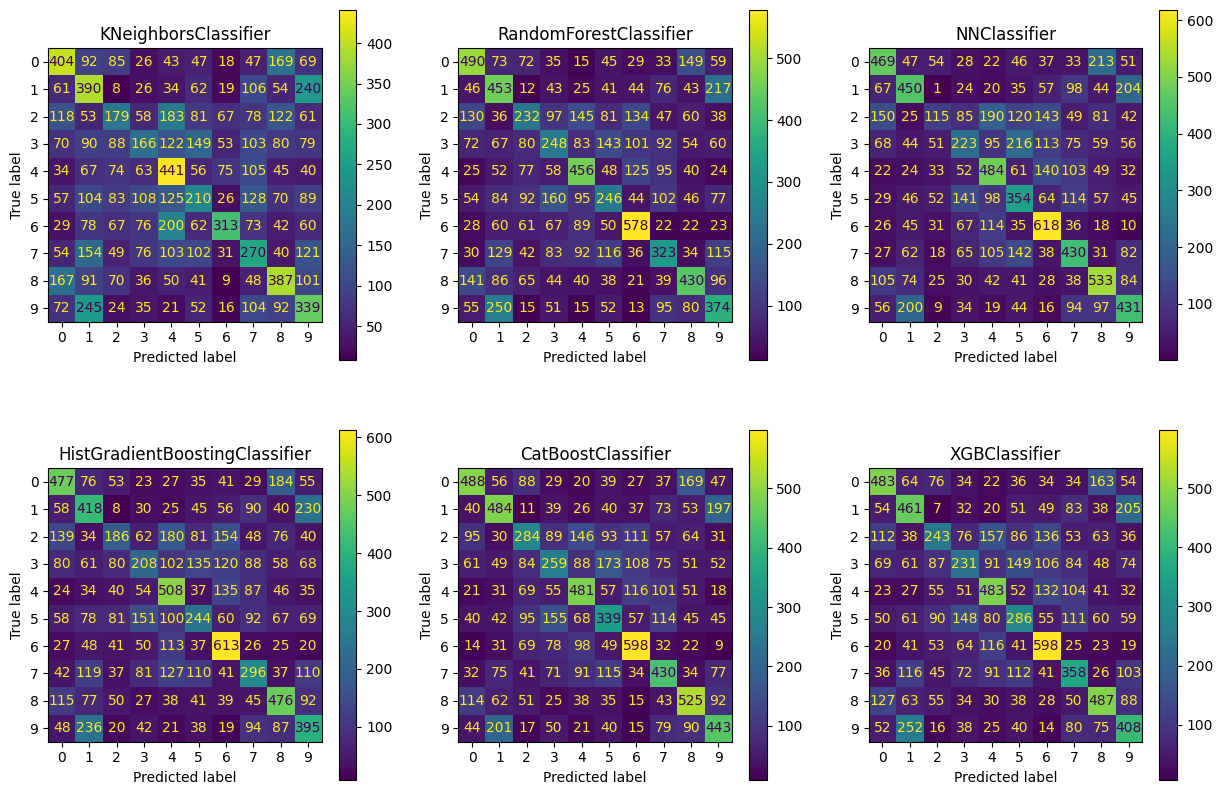

In [24]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### PCA

In [25]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 64, random_state = 42)

train_features = pca.fit_transform(train_features)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features = pca.transform(test_features)

train_features.shape, test_features.shape

Explained variance 0.96
[0.517, 0.24, 0.037, 0.026, 0.016, 0.011, 0.01, 0.01, 0.009, 0.008, 0.006, 0.006, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


((50000, 64), (10000, 64))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3141, 'TOP-2 Accuracy': 0.4957, 'TOP-3 Accuracy': 0.6186, 'TOP-4 Accuracy': 0.7172, 'TOP-5 Accuracy': 0.788, 'TOP-6 Accuracy': 0.8501, 'TOP-7 Accuracy': 0.8993, 'TOP-8 Accuracy': 0.9403, 'TOP-9 Accuracy': 0.9723, 'AUC-ROC': 0.7498732388888889, 'Precision': 0.31874230135369164, 'Recall': 0.3141, 'F1-score': 0.31097932148128066}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3465, 'TOP-2 Accuracy': 0.5332, 'TOP-3 Accuracy': 0.6556, 'TOP-4 Accuracy': 0.7449, 'TOP-5 Accuracy': 0.8142, 'TOP-6 Accuracy': 0.8726, 'TOP-7 Accuracy': 0.9174, 'TOP-8 Accuracy': 0.9512, 'TOP-9 Accuracy': 0.9801, 'AUC-ROC': 0.7750957944444443, 'Precision': 0.340784833048496, 'Recall': 0.34650000000000003, 'F1-score': 0.34124817784455896}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001FF2526D6F0>
Input to LazyLinear:

100%|██████████| 25/25 [00:31<00:00,  1.27s/it, loss=1.08e+5, val_acc=0.369]


{'classifier': 'NNClassifier', 'Accuracy': 0.3688, 'TOP-2 Accuracy': 0.5653, 'TOP-3 Accuracy': 0.6849, 'TOP-4 Accuracy': 0.7724, 'TOP-5 Accuracy': 0.8387, 'TOP-6 Accuracy': 0.8878, 'TOP-7 Accuracy': 0.9272, 'TOP-8 Accuracy': 0.9589, 'TOP-9 Accuracy': 0.9816, 'AUC-ROC': 0.7897902222222222, 'Precision': 0.35899756042627534, 'Recall': 0.36879999999999996, 'F1-score': 0.3555319031368044}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3379, 'TOP-2 Accuracy': 0.5253, 'TOP-3 Accuracy': 0.6494, 'TOP-4 Accuracy': 0.7421, 'TOP-5 Accuracy': 0.8143, 'TOP-6 Accuracy': 0.8745, 'TOP-7 Accuracy': 0.9224, 'TOP-8 Accuracy': 0.9555, 'TOP-9 Accuracy': 0.9813, 'AUC-ROC': 0.7729896000000002, 'Precision': 0.3290543897574128, 'Recall': 0.3379, 'F1-score': 0.329202696362994}
Fitting <catboost.core.CatBoostClassifier object at 0x000001FF22AD1B40>
Learning rate set to

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3141,0.4957,0.6186,0.7172,0.7880,0.8501,0.8993,0.9403,0.9723,0.749873,0.318742,0.3141,0.310979
1,RandomForestClassifier,0.3465,0.5332,0.6556,0.7449,0.8142,0.8726,0.9174,0.9512,0.9801,0.775096,0.340785,0.3465,0.341248
2,NNClassifier,0.3688,0.5653,0.6849,0.7724,0.8387,0.8878,0.9272,0.9589,0.9816,0.789790,0.358998,0.3688,0.355532
3,HistGradientBoostingClassifier,0.3379,0.5253,0.6494,0.7421,0.8143,0.8745,0.9224,0.9555,0.9813,0.772990,0.329054,0.3379,0.329203
4,CatBoostClassifier,0.3859,0.5837,0.7100,0.7935,0.8578,0.9083,0.9415,0.9702,0.9888,0.813463,0.380380,0.3859,0.382362
5,XGBClassifier,0.3653,0.5589,0.6829,0.7702,0.8355,0.8904,0.9350,0.9633,0.9845,0.793719,0.358350,0.3653,0.359679


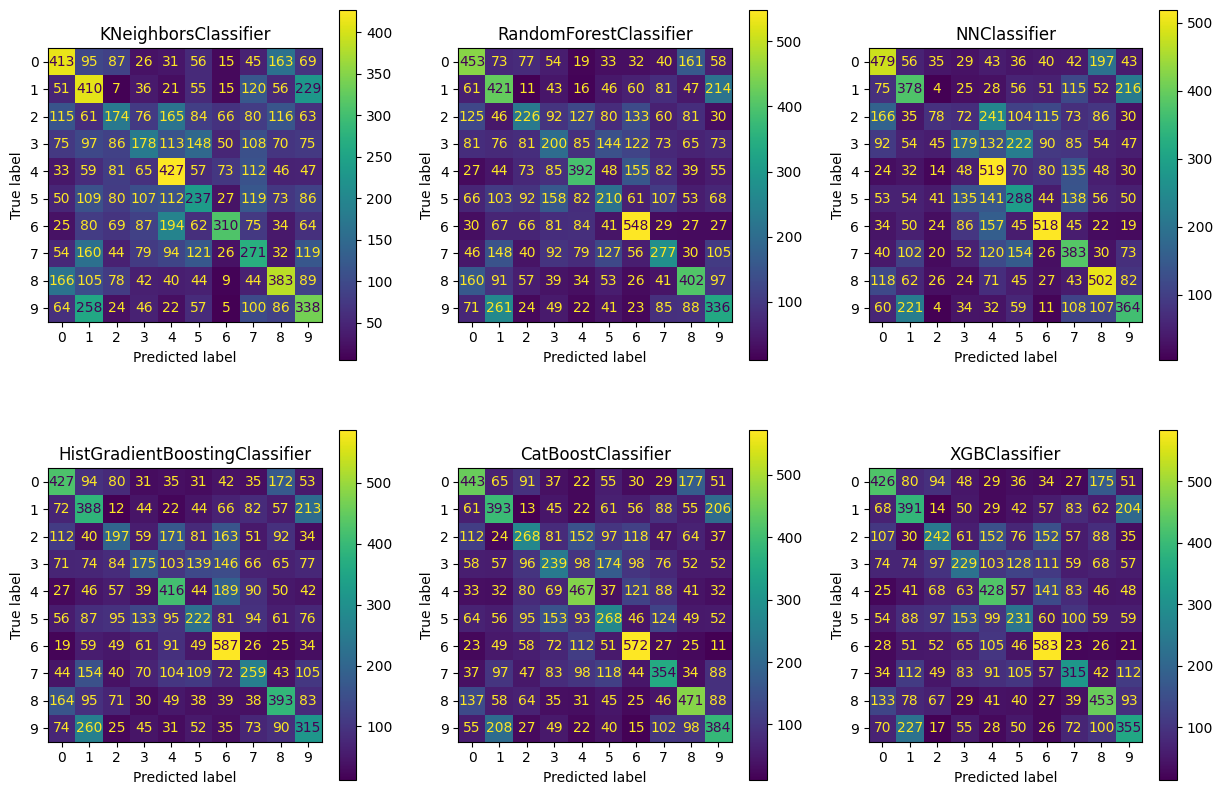

In [26]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)